In [152]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

files = list(os.walk("../scrapy_projects/etoro/etoro/"))[0][2]
etoro_portfolio_paths = [f for f in files if f.startswith("investor_dashboard")]
etoro_investor_paths = [f for f in files if f.startswith("investor_portfolio")]


etoro_investors = []
for path in etoro_investor_paths:
    with open(f"../scrapy_projects/etoro/etoro/{path}","r") as f:
        _ = json.load(f)
        etoro_investors.extend(_)
        
with open(f"../scrapy_projects/etoro/etoro/{ sorted(etoro_portfolio_paths)[-1]}","r") as f:
    _ = json.load(f)
    etoro_port = _
        
        
panda_investors = []
for investor in etoro_investors:
    for item in investor["items"]:
        row = {"investor_name":investor["investor_name"],
                    "date":investor["datetime"],
                    "company":item["company_ticker"],
                    "type":item["type"],
                    "invested":item["invested"].replace("<","").replace("%","")}
        panda_investors.append(row)
        
        
        
df = pd.DataFrame(panda_investors)
df = df.astype({'invested': 'float32'})
df["date"] = pd.to_datetime(df["date"],format='%y-%m-%d')

investor_summary_df = pd.DataFrame(etoro_port)


investor_summary_df = investor_summary_df.set_index("CustomerId")
investor_summary_df = investor_summary_df[['Gain', 'DailyGain', 'ThisWeekGain', 'RiskScore', 'MaxDailyRiskScore',
       'MaxMonthlyRiskScore', 'Copiers', 'CopyTradesPct', 'VirtualCopiers', 'Trades', 'WinRatio',
       'DailyDD', 'WeeklyDD']]

for col in investor_summary_df:
    investor_summary_df[col] = investor_summary_df[col].apply(lambda x: str(x).replace("$","").replace("+","").replace("M","")).astype(np.float32)

    
investor_summary = StandardScaler().fit_transform(investor_summary_df)
kmeans = KMeans(10)
kmeans.fit(investor_summary)
investor_summary_df["k_mean_cluster"] = kmeans.predict(investor_summary)

investor_summary_df = investor_summary_df[investor_summary_df["Copiers"]>100]
summ = investor_summary_df.groupby("k_mean_cluster").mean()
summ["count"] = investor_summary_df.groupby("k_mean_cluster")["k_mean_cluster"].count()
summ = summ.sort_values('count',ascending=False,inplace=False)


In [153]:
summ

,Gain,DailyGain,ThisWeekGain,RiskScore,MaxDailyRiskScore,MaxMonthlyRiskScore,Copiers,CopyTradesPct,VirtualCopiers,Trades,WinRatio,DailyDD,WeeklyDD,count
k_mean_cluster,,,,,,,,,,,,,,
1,62.103531,-1.929706,-1.576177,4.088235,6.323529,5.411765,922.676453,0.444843,0.0,422.441162,73.919594,-7.594412,-10.718823,34
0,65.162811,-2.075938,-1.360625,4.812500,6.531250,5.281250,547.656250,0.442443,0.0,296.500000,70.800056,-4.459375,-6.810000,32
6,33.545002,0.013667,1.230000,3.266667,4.966667,3.866667,824.599976,0.104084,0.0,407.933319,72.973877,-3.198667,-4.430000,30
7,107.223915,-3.235652,-3.205217,5.260870,7.043478,5.913043,574.173889,0.313433,0.0,580.000000,69.858505,-7.301739,-10.289130,23
8,64.514999,-1.586667,-1.451667,3.833333,6.333333,5.000000,11644.500000,0.000000,0.0,831.166687,78.170906,-6.310000,-7.995000,6
4,96.094002,-1.264000,-1.424000,4.400000,5.800000,4.400000,683.799988,0.153361,0.0,5826.399902,71.636887,-5.240000,-8.092000,5


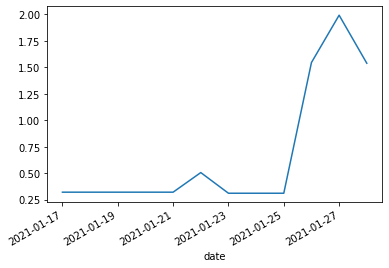

In [76]:
df[df.company=='LKQ'].groupby('date')['invested'].mean().plot()

In [37]:
len(df.company.unique())

2224

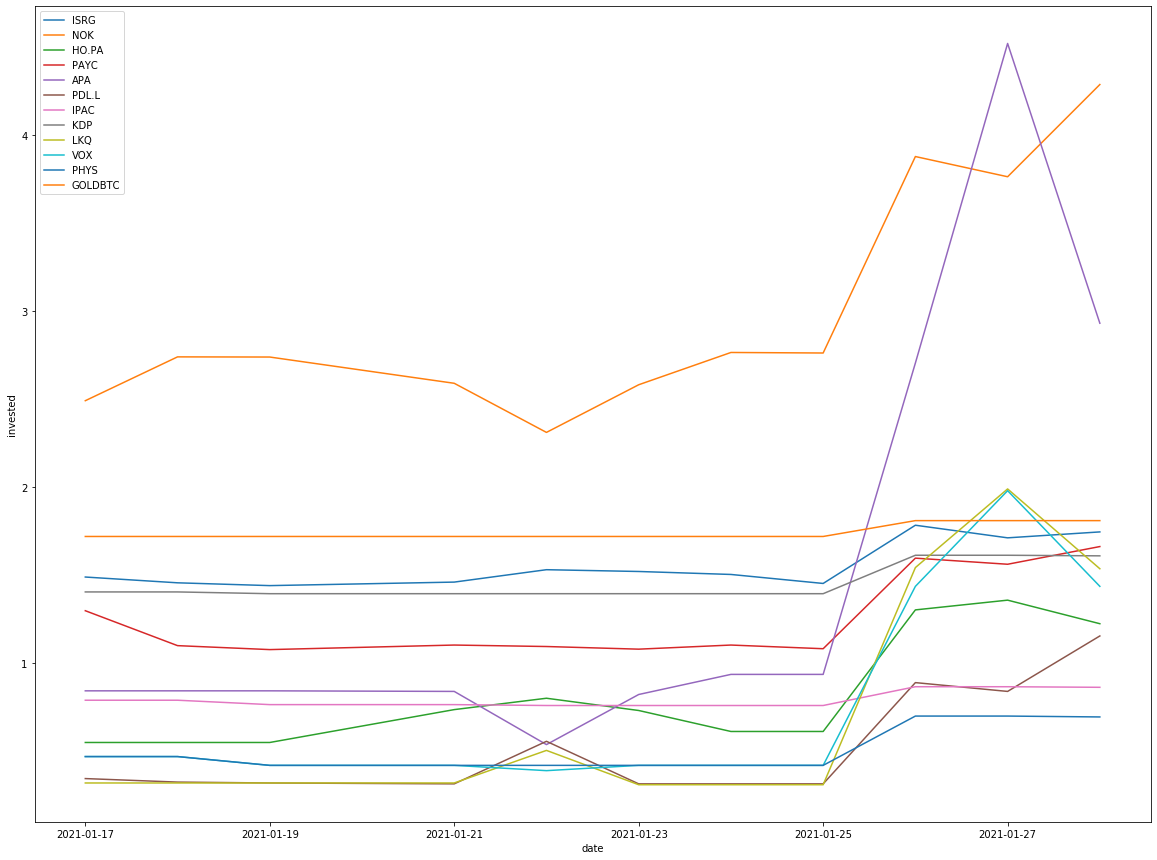

In [40]:
plt.figure(figsize=(20,15))
for stock_name in df.company.value_counts()[:2000].index:
    plot_data = df[df.company==stock_name].groupby('date')['invested'].mean()
    if plot_data[-3:].mean() > plot_data[:-3].mean() + 2*plot_data.std():
        sns.lineplot(x=plot_data.index,y=plot_data,label=stock_name)       
plt.legend()